In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import pandas as pd
import distrax
import wandb
import optax
import chex

import abc
from typing import Optional, Callable, Union, Tuple, Dict, Any, Sequence, List
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [6.0, 4.0]

key = jax.random.PRNGKey(0)


Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



W0000 00:00:1729165020.681055 5940521 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1729165020.690889 5940521 service.cc:145] XLA service 0x147d8a210 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729165020.690907 5940521 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1729165020.692277 5940521 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1729165020.692298 5940521 mps_client.cc:384] XLA backend will use up to 22906109952 bytes on device 0 for SimpleAllocator.


### Target Density

In [2]:
def plot_contours_2D(
    log_prob_func, ax: Optional[plt.Axes] = None, bound: float = 3, levels: int = 20
):
    """Plot the contours of a 2D log prob function."""
    if ax is None:
        fig, ax = plt.subplots(1)
    n_points = 200
    x_points_dim1 = np.linspace(-bound, bound, n_points)
    x_points_dim2 = np.linspace(-bound, bound, n_points)
    x_points = np.array(list(product(x_points_dim1, x_points_dim2)))
    log_probs = log_prob_func(x_points)
    log_probs = jnp.clip(log_probs, a_min=-1000, a_max=None)
    x1 = x_points[:, 0].reshape(n_points, n_points)
    x2 = x_points[:, 1].reshape(n_points, n_points)
    z = log_probs.reshape(n_points, n_points)
    ax.contour(x1, x2, z, levels=levels)


def plot_marginal_pair(
    samples: chex.Array,
    ax: Optional[plt.Axes] = None,
    marginal_dims: Tuple[int, int] = (0, 1),
    bounds: Tuple[float, float] = (-5, 5),
    alpha: float = 0.5,
):
    """Plot samples from marginal of distribution for a given pair of dimensions."""
    if not ax:
        fig, ax = plt.subplots(1)
    samples = jnp.clip(samples, bounds[0], bounds[1])
    ax.plot(
        samples[:, marginal_dims[0]], samples[:, marginal_dims[1]], "o", alpha=alpha
    )


def plot_history(history):
    """Agnostic history plotter for quickly plotting a dictionary of logging info."""
    figure, axs = plt.subplots(len(history), 1, figsize=(7, 3 * len(history.keys())))
    if len(history.keys()) == 1:
        axs = [axs]  # make iterable
    elif len(history.keys()) == 0:
        return
    for i, key in enumerate(history):
        data = pd.Series(history[key])
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        if sum(data.isna()) > 0:
            data = data.dropna()
            print(f"NaN encountered in {key} history")
        axs[i].plot(data)
        axs[i].set_title(key)
    plt.tight_layout()


LogProbFn = Callable[[chex.Array], chex.Array]


def calculate_log_forward_ess(
    log_w: chex.Array, mask: Optional[chex.Array] = None, log_Z: Optional[float] = None
) -> chex.Array:
    """Calculate forward ess, either using exact log_Z if it is known, or via estimating it from the samples.
    NB: log_q = p(x)/q(x) where x ~ p(x).
    """
    if mask is None:
        mask = jnp.ones_like(log_w)

    chex.assert_equal_shape((log_w, mask))
    log_w = jnp.where(mask, log_w, jnp.zeros_like(log_w))  # make sure log_w finite

    if log_Z is None:
        log_z_inv = jax.nn.logsumexp(-log_w, b=mask) - jnp.log(jnp.sum(mask))
    else:
        log_z_inv = -log_Z

    # log ( Z * E_p[p(x)/q(x)] )
    log_z_times_expectation_p_of_p_div_q = jax.nn.logsumexp(log_w, b=mask) - jnp.log(
        jnp.sum(mask)
    )
    # ESS (as fraction of 1) = 1/E_p[p(x)/q(x)]
    # ESS = Z / ( Z * E_p[p(x)/q(x)] )
    # Log ESS = - log Z^{-1} -  log ( Z * E_p[p(x)/q(x)] )
    log_forward_ess = -log_z_inv - log_z_times_expectation_p_of_p_div_q
    return log_forward_ess


class Target(abc.ABC):
    """Abstraction of target distribution that allows our training and evaluation scripts to be generic."""

    def __init__(
        self,
        dim: int,
        log_Z: Optional[float],
        can_sample: bool,
        n_plots: int,
        n_model_samples_eval: int,
        n_target_samples_eval: Optional[int],
    ):
        self.n_model_samples_eval = n_model_samples_eval
        self.n_target_samples_eval = n_target_samples_eval
        self._dim = dim
        self._log_Z = log_Z
        self._n_plots = n_plots
        self._can_sample = can_sample

    @property
    def dim(self) -> int:
        """Dimensionality of the problem."""
        return self._dim

    @property
    def n_plots(self) -> int:
        """Number of matplotlib axes that samples are visualized on."""
        return self._n_plots

    @property
    def can_sample(self) -> bool:
        """Whether the target may be sampled form."""
        return self._can_sample

    @property
    def log_Z(self) -> Union[int, None]:
        """Log normalizing constant if available."""
        return self._log_Z

    def sample(self, seed: chex.PRNGKey, sample_shape: chex.Shape) -> chex.Array:
        raise NotImplementedError

    @abc.abstractmethod
    def log_prob(self, value: chex.Array) -> chex.Array:
        """(Possibly unnormalized) target probability density."""

    def evaluate(
        self,
        model_log_prob_fn: LogProbFn,
        model_sample_and_log_prob_fn: Callable[
            [chex.PRNGKey, chex.Shape], Tuple[chex.Array, chex.Array]
        ],
        key: chex.PRNGKey,
    ) -> dict:
        """Evaluate a model. Note that reverse ESS will be estimated separately, so should not be estimated here."""
        key1, key2 = jax.random.split(key)

        info = {}

        if self.can_sample:
            assert self.n_target_samples_eval is not None
            samples_p = self.sample(key1, (self.n_target_samples_eval,))
            log_prob_q = model_log_prob_fn(samples_p)
            log_prob_p = self.log_prob(samples_p)
            log_w = log_prob_p - log_prob_q
            log_forward_ess = calculate_log_forward_ess(log_w, log_Z=self.log_Z)
            info.update(
                log_lik=jnp.mean(log_prob_q),
                log_forward_ess=log_forward_ess,
                forward_ess=jnp.exp(log_forward_ess),
            )
        return info

    @abc.abstractmethod
    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """Visualise samples from the model."""

In [3]:
class GaussianMixture2D(Target):
    """
    2-D Guassian mixture.
    https://arxiv.org/abs/2310.02679
    https://github.com/zdhNarsil/Diffusion-Generative-Flow-Samplers/blob/main/target/distribution/gm.py
    """

    def __init__(self, scale=0.5477222, width_in_n_modes: int = 3):
        dim = 2
        super().__init__(
            dim=dim,
            log_Z=0.0,
            can_sample=True,
            n_plots=1,
            n_model_samples_eval=1000,
            n_target_samples_eval=2000,
        )
        means_1_dim = jnp.arange(width_in_n_modes) * 5
        means_1_dim = means_1_dim - jnp.mean(means_1_dim)  # Centre
        mean_ls = list(product(list(means_1_dim), list(means_1_dim)))

        nmode = len(mean_ls)
        mean = jnp.stack([jnp.array(xy) for xy in mean_ls])
        comp = distrax.Independent(
            distrax.Normal(loc=mean, scale=jnp.ones_like(mean) * scale),
            reinterpreted_batch_ndims=1,
        )
        mix = distrax.Categorical(logits=jnp.ones(nmode))
        self.gmm = distrax.MixtureSameFamily(
            mixture_distribution=mix, components_distribution=comp
        )
        self._plot_bound = mean.max() + 3

    def log_prob(self, x):
        log_prob = self.gmm.log_prob(x)
        return log_prob

    def sample(self, seed, sample_shape):
        return self.gmm.sample(seed=seed, sample_shape=sample_shape)

    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """Visualise samples from the model."""
        assert len(axes) == self.n_plots

        ax = axes[0]
        plot_contours_2D(self.log_prob, ax, bound=self._plot_bound, levels=20)
        plot_marginal_pair(samples, ax, bounds=(-self._plot_bound, self._plot_bound))


class GMM(Target):
    def __init__(
        self,
        dim: int = 2,
        n_mixes: int = 40,
        loc_scaling: float = 40,
        scale_scaling: float = 1.0,
        seed: int = 0,
    ) -> None:
        super().__init__(
            dim=dim,
            log_Z=0.0,
            can_sample=True,
            n_plots=1,
            n_model_samples_eval=1000,
            n_target_samples_eval=1000,
        )

        self.seed = seed
        self.n_mixes = n_mixes

        key = jax.random.PRNGKey(seed)
        logits = jnp.ones(n_mixes)
        mean = (
            jax.random.uniform(shape=(n_mixes, dim), key=key, minval=-1.0, maxval=1.0)
            * loc_scaling
        )
        scale = jnp.ones(shape=(n_mixes, dim)) * scale_scaling

        mixture_dist = distrax.Categorical(logits=logits)
        components_dist = distrax.Independent(
            distrax.Normal(loc=mean, scale=scale), reinterpreted_batch_ndims=1
        )
        self.distribution = distrax.MixtureSameFamily(
            mixture_distribution=mixture_dist,
            components_distribution=components_dist,
        )

        self._plot_bound = loc_scaling * 1.5

    def log_prob(self, x: chex.Array) -> chex.Array:
        log_prob = self.distribution.log_prob(x)
        return log_prob

    def sample(self, seed: chex.PRNGKey, sample_shape: chex.Shape = ()) -> chex.Array:
        return self.distribution.sample(seed=seed, sample_shape=sample_shape)

    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """Visualise samples from the model."""
        assert len(axes) == self.n_plots
        ax = axes[0]
        plot_marginal_pair(samples, ax, bounds=(-self._plot_bound, self._plot_bound))
        if self.dim == 2:
            plot_contours_2D(self.log_prob, ax, bound=self._plot_bound, levels=50)

In [4]:
class MultivariateGaussian(Target):
    """
    Multivariate Gaussian Distribution with Sigma * I covariance.

    Parameters:
    - dim: int
        Dimensionality of the Gaussian.
    - sigma: float or jnp.ndarray, default=1.0
        Standard deviation of the distribution. If a float is provided, the same sigma is used for all dimensions.
        If an array is provided, it should have shape (dim,) for per-dimension sigma.
    - plot_bound_factor: float, default=3.0
        Factor to determine the plotting bounds based on sigma.
    """

    def __init__(
        self, dim: int = 2, sigma: float = 1.0, plot_bound_factor: float = 3.0, **kwargs
    ):
        """
        Initializes the MultivariateGaussian distribution.

        Args:
            dim (int): Dimensionality of the Gaussian.
            sigma (float or jnp.ndarray): Standard deviation(s). Scalar for isotropic, array for anisotropic.
            plot_bound_factor (float): Factor to determine the plotting bounds.
            **kwargs: Additional arguments to pass to the base Target class.
        """
        super().__init__(
            dim=dim,
            log_Z=0.0,  # Not used since it's a single Gaussian
            can_sample=True,
            n_plots=1,
            n_model_samples_eval=1000,
            n_target_samples_eval=1000,
            **kwargs,
        )

        self.sigma = jnp.asarray(sigma)
        if self.sigma.ndim == 0:
            # Scalar sigma: isotropic covariance
            scale_diag = jnp.full((dim,), self.sigma)
        else:
            # Per-dimension sigma
            if self.sigma.shape[0] != dim:
                raise ValueError(
                    f"Sigma shape {self.sigma.shape} does not match dimension {dim}."
                )
            scale_diag = self.sigma

        # Initialize the Multivariate Normal Distribution
        self.distribution = distrax.MultivariateNormalDiag(
            loc=jnp.zeros(dim), scale_diag=scale_diag
        )

        # Determine plot bounds based on sigma
        if self.sigma.ndim == 0:
            bound = self.sigma * plot_bound_factor
        else:
            bound = jnp.max(self.sigma) * plot_bound_factor
        self._plot_bound = float(bound)

    def log_prob(self, x: chex.Array) -> chex.Array:
        """
        Computes the log probability density of the input samples.

        Args:
            x (chex.Array): Input samples with shape (..., dim).

        Returns:
            chex.Array: Log probability densities.
        """
        return self.distribution.log_prob(x)

    def sample(self, seed: chex.PRNGKey, sample_shape: chex.Shape = ()) -> chex.Array:
        """
        Generates samples from the distribution.

        Args:
            seed (chex.PRNGKey): JAX random key for reproducibility.
            sample_shape (chex.Shape): Shape of the samples to generate.

        Returns:
            chex.Array: Generated samples with shape `sample_shape + (dim,)`.
        """
        return self.distribution.sample(seed=seed, sample_shape=sample_shape)

    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """
        Visualizes the distribution and samples.

        Args:
            samples (chex.Array): Samples to visualize.
            axes (List[plt.Axes]): List of matplotlib axes for plotting.
        """
        assert (
            len(axes) == self.n_plots
        ), f"Expected {self.n_plots} axes, got {len(axes)}."

        ax = axes[0]
        if self.dim == 2:
            # Plot contour lines for the distribution
            plot_contours_2D(self.log_prob, ax, bound=self._plot_bound, levels=20)
            # Overlay scatter plot of samples
            plot_marginal_pair(
                samples, ax, bounds=(-self._plot_bound, self._plot_bound)
            )
        else:
            # For higher dimensions, visualize projections or other summaries
            ax.hist(samples, bins=50, density=True)
            ax.set_title(f"Histogram of samples in 1D projection (dim={self.dim})")
            ax.set_xlim(-self._plot_bound, self._plot_bound)
            ax.set_xlabel("Value")
            ax.set_ylabel("Density")

In [5]:
key, subkey = jax.random.split(key)
initial = MultivariateGaussian(dim=2, sigma=20.0)

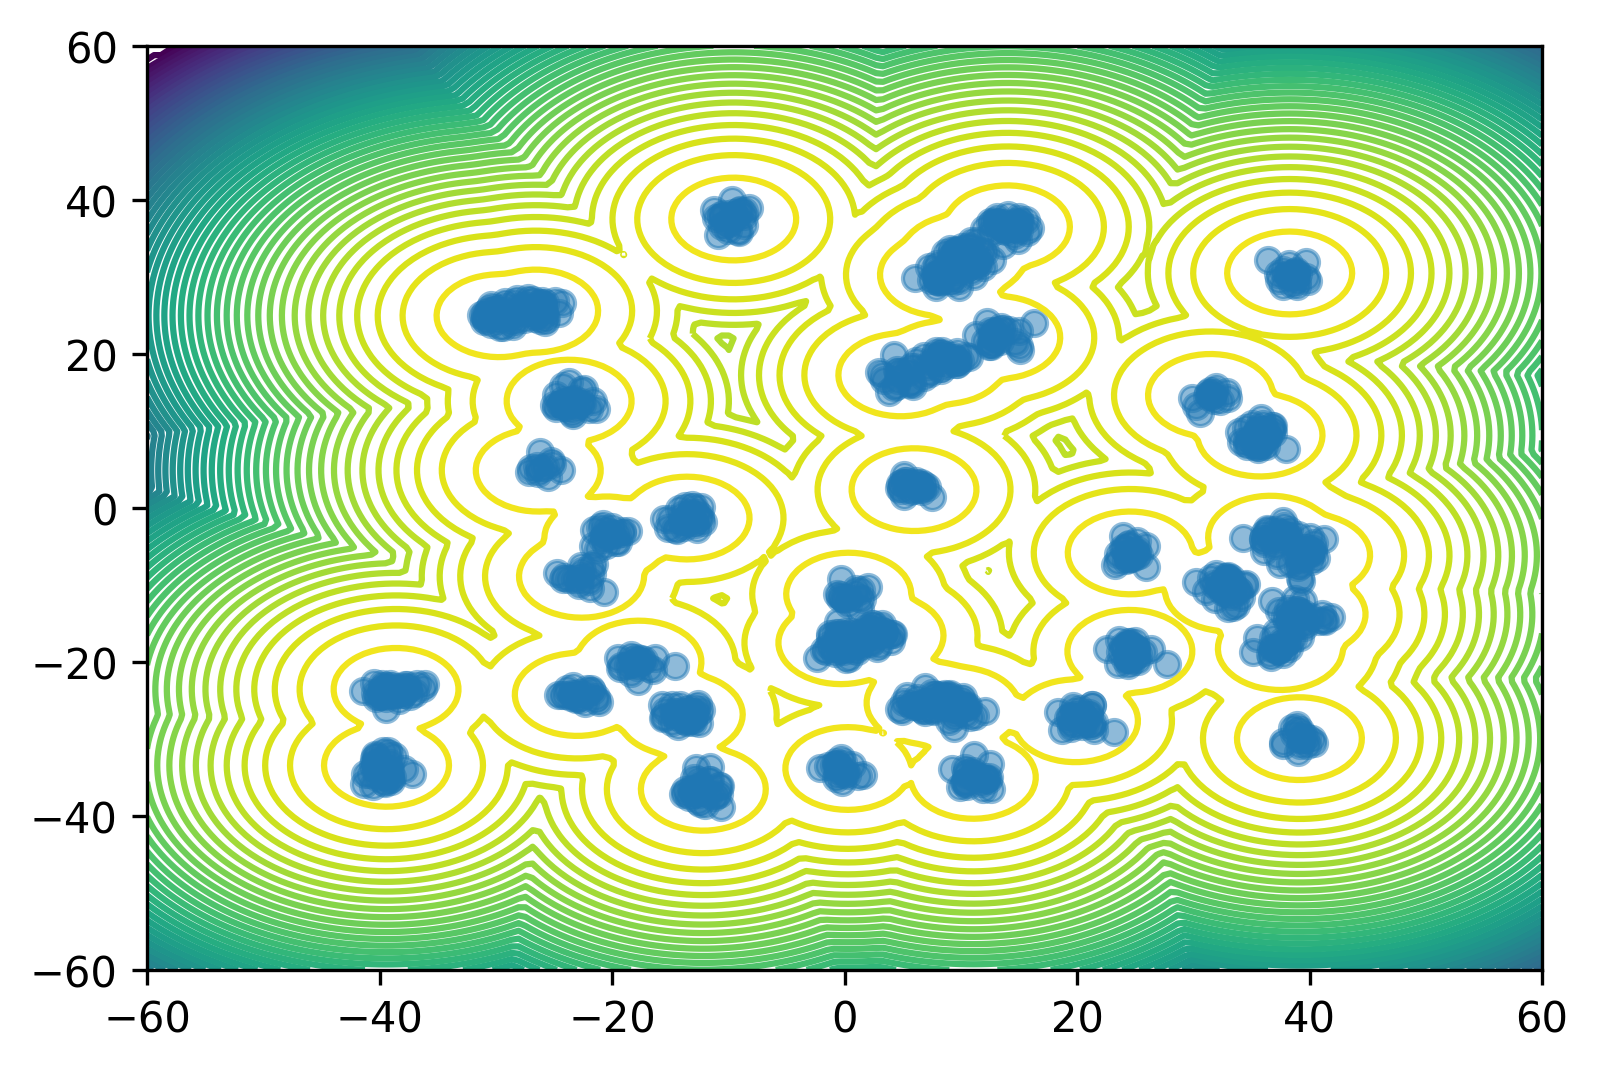

In [6]:
key, subkey = jax.random.split(key)
gmm = GMM(n_mixes=40, seed=subkey[0])
gmm.visualise(gmm.sample(jax.random.PRNGKey(0), (1000,)), [plt.gca()])

### Time-Dependent Velocity Field

In [7]:
class TimeVelocityField(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, key, input_dim, hidden_dim, depth=3):
        # Define an MLP with time as an input
        self.mlp = eqx.nn.MLP(
            in_size=input_dim + 1,  # x and t
            out_size=input_dim,
            width_size=hidden_dim,
            activation=jax.nn.sigmoid,
            depth=depth,
            key=key,
        )

    def __call__(self, x, t):
        # Concatenate x and t
        t_expanded = jnp.array([t])
        x_t = jnp.concatenate([x, t_expanded], axis=-1)
        return self.mlp(x_t)

### Time-Dependent Density

In [15]:
class PThetaNetwork(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, key, input_dim, hidden_dim, depth=3):
        # Define an MLP with time as an input
        self.mlp = eqx.nn.MLP(
            in_size=input_dim + 1,  # x and t
            out_size=1,
            width_size=hidden_dim,
            activation=jax.nn.sigmoid,
            depth=depth,
            key=key,
        )

    def __call__(self, x, t):
        # Concatenate x and t
        t_expanded = jnp.array([t])
        x_t = jnp.concatenate([x, t_expanded], axis=-1)
        return t * (1 - t) * self.mlp(x_t).squeeze()


### Parameterised Annealing

In [18]:
def score_nu(x):
    return jax.grad(target_log_density)(x)

def score_p_theta(p_theta, x, t):
    return jax.grad(p_theta)(x, t)

def target_log_density(x):
    return gmm.log_prob(x)


def initial_log_density(x):
    return initial.log_prob(x)


def sample_initial(key, num_samples, dim):
    return initial.sample(key, (num_samples,))


def log_unnormalized_density(p_theta, x, t):
    log_density = (1 - t) * initial_log_density(x) + t * target_log_density(x) + p_theta(x, t)
    return log_density


def time_derivative_log_density(p_theta, x, t):
    # Compute ∂_t log π_t(x) = log ν(x) - log μ(x) + ∂_t p_θ(x, t)
    dt_log_density = target_log_density(x) - initial_log_density(x) + jax.grad(p_theta, argnums=1)(x, t)

    return dt_log_density


def score_function(p_theta, x, t):
    score = (1 - t) * jax.grad(initial_log_density)(x) + t * score_nu(x) + score_p_theta(p_theta, x, t)
    return score


@eqx.filter_jit
def divergence_velocity(v_theta, x, t):
    def v_x(x):
        return v_theta(x, t)

    jacobian = jax.jacfwd(v_x)(x)
    div_v = jnp.trace(jacobian)
    return div_v


In [25]:
def sample_langevin_dynamics(key, p_theta, xs, t, num_steps=3, eta=0.01):
    """
    Sample from the Langevin dynamics using the score function and noise.

    """

    def step(carry, _):
        i, x, subkey = carry
        noise = jax.random.normal(subkey, shape=x.shape)
        g = jax.vmap(lambda x: score_function(p_theta, x, t))(x)

        x = x + (eta**2 / 2.0) * g + eta * noise
        return (i + 1, x, jax.random.fold_in(subkey, i)), None

    (_, final_xs, _), _ = jax.lax.scan(step, (0, xs, key), None, length=num_steps)
    return final_xs


@eqx.filter_jit
def time_batched_sample_langevin_dynamics(key, p_theta, xs, ts, num_steps=3, eta=0.01):
    """
    Sample from the Langevin dynamics using the score function and noise.

    """
    keys = jax.random.split(key, ts.shape[0] + 1)
    key, subkeys = keys[0], keys[1:]

    final_xs = jax.vmap(
        lambda x, t, subkey: sample_langevin_dynamics(subkey, p_theta, x, t, num_steps, eta)
    )(xs, ts, subkeys)

    return final_xs

In [26]:
@eqx.filter_jit
def generate_samples_without_weight(
    v_theta: Callable,
    initial_samples: jnp.ndarray,
    ts: jnp.ndarray,
) -> jnp.ndarray:
    def step(carry, t):
        x_prev, t_prev = carry
        samples = x_prev + (t - t_prev) * jax.vmap(lambda x: v_theta(x, t))(x_prev)
        return (samples, t), samples

    _, output = jax.lax.scan(step, (initial_samples, 0.0), ts)

    return output

def generate_samples(
    v_theta: Callable,
    num_samples: int,
    key: jnp.ndarray,
    ts: jnp.ndarray,
) -> jnp.ndarray:
    key, subkey = jax.random.split(key)
    initial_samples = sample_initial(subkey, num_samples, gmm.dim)
    samples = generate_samples_without_weight(v_theta, initial_samples, ts)
    return samples


@eqx.filter_jit
def generate_samples_with_mcmc(
    p_theta: Callable,
    v_theta: Callable,
    num_samples: int,
    key: jnp.ndarray,
    ts: jnp.ndarray,
    num_steps: int = 3,
    eta: float = 0.01,
) -> jnp.ndarray:
    key, subkey = jax.random.split(key)
    initial_samples = sample_initial(subkey, num_samples, gmm.dim)
    samples = generate_samples_without_weight(v_theta, initial_samples, ts)
    final_samples = time_batched_sample_langevin_dynamics(
        subkey, p_theta, samples, ts, num_steps, eta
    )

    return final_samples

In [32]:
def epsilon(p_theta, v_theta, x, dt_log_density, t):
    # Compute LHS
    score = score_function(p_theta, x, t)
    div_v = divergence_velocity(v_theta, x, t)
    v = v_theta(x, t)
    lhs = div_v + jnp.dot(v, score)

    # Compute ε(x; θ)
    eps = jnp.nan_to_num(lhs + dt_log_density, posinf=1.0, neginf=-1.0)

    return eps


batched_epsilon = jax.vmap(epsilon, in_axes=(None, None, 0, 0, None))
time_batched_epsilon = eqx.filter_jit(
    jax.vmap(batched_epsilon, in_axes=(None, None, 0, 0, 0))
)


# Loss function
def loss_fn(params, xs, ts, weightings=1.0):
    # xs is of shape (time, n_samples, dim) and ts is of shape (time,)
    p_theta = params["p_theta"]
    v_theta = params["v_theta"]

    # Compute time derivative of log density
    dt_log_unormalised_density = jax.vmap(
        lambda xs, t: jax.vmap(lambda x: time_derivative_log_density(p_theta, x, t))(xs),
        in_axes=(0, 0),
    )(xs, ts)
    dt_log_density = dt_log_unormalised_density - jnp.mean(
        dt_log_unormalised_density, axis=-1, keepdims=True
    )
    epsilons = time_batched_epsilon(p_theta, v_theta, xs, dt_log_density, ts)
    # Mean squared error
    loss = jnp.mean((epsilons * weightings) ** 2)

    return loss

In [33]:
p_theta = PThetaNetwork(key, 2, 128)
v_theta = TimeVelocityField(key, 2, 128)

params = {"p_theta": p_theta, "v_theta": v_theta}
ts = jnp.linspace(0, 1, 16)
samples = jax.random.normal(key, (16, 100, 2))

In [24]:
loss_fn(p_theta, v_theta, samples, ts)

Array(41.933464, dtype=float32)

In [34]:
eqx.filter_value_and_grad(loss_fn)(params, samples, ts)

(Array(43.450672, dtype=float32),
 {'p_theta': PThetaNetwork(
    mlp=MLP(
      layers=(
        Linear(
          weight=f32[128,3],
          bias=f32[128],
          in_features=3,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[1,128],
          bias=f32[1],
          in_features=128,
          out_features=1,
          use_bias=True
        )
      ),
      activation=None,
      final_activation=None,
      use_bias=True,
      use_final_bias=True,
      in_size=3,
      out_size=1,
      width_size=128,
      depth=3
    )
  ),
  'v_theta': TimeVelocityField(
    mlp=MLP(
      layers=(
        Linear(
      

### Training

In [37]:
def train_velocity_field_with_mcmc(
    p_theta,
    v_theta,
    key,
    N=512,
    num_epochs=200,
    num_steps=100,
    learning_rate=1e-03,
    T=32,
    gradient_norm=1.0,
    eta=1.0,
    num_mcmc_steps=3,
):
    """
    Train the velocity field v_theta at time step k using samples xs.
    """
    gradient_clipping = optax.clip_by_global_norm(gradient_norm)
    optimizer = optax.chain(gradient_clipping, optax.adamw(learning_rate=learning_rate))

    params = {'v_theta': v_theta, 'p_theta': p_theta}
    opt_state = optimizer.init(eqx.filter(params, eqx.is_inexact_array))


    key, subkey = jax.random.split(key)
    ts = jnp.linspace(0, 1, T)

    @eqx.filter_jit
    def step(params, opt_state, xs):
        loss, grads = eqx.filter_value_and_grad(loss_fn)(params, xs, ts)
        updates, opt_state = optimizer.update(grads, opt_state, params)

        params = eqx.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(num_epochs):
        key, subkey = jax.random.split(key)
        samples = generate_samples_with_mcmc(p_theta, v_theta, N, subkey, ts, num_mcmc_steps, eta)

        epoch_loss = 0.0
        for s in range(num_steps):
            params, opt_state, loss = step(params, opt_state, samples)
            epoch_loss += loss

            if s % 20 == 0:
                wandb.log({"epoch": epoch, "loss": loss})

        avg_loss = epoch_loss / num_steps
        print(f"Epoch {epoch}, Average Loss: {avg_loss}")
        wandb.log({"epoch": epoch, "average_loss": avg_loss})

        if epoch % 2 == 0:
            val_samples = generate_samples(v_theta, N, subkey, ts)
            fig, axes = plt.subplots(1, 1, figsize=(6, 6))

            # Use your target's visualise method
            gmm.visualise(val_samples[-1], [axes])

            # Save the plot to a buffer
            wandb.log({"validation_samples": wandb.Image(fig)})
            plt.close(fig)

    return params


In [38]:
# Define problem parameters
input_dim = 2  # Dimensionality of the problem
T = 64  # Number of time steps
N = 1024  # Number of samples for training at each time step
num_epochs = 2000
num_steps = 100
learning_rate = 1e-03
hidden_dim = 128
p_theta_hidden_dim = 32
p_theta_depth = 2

num_mcmc_steps = 5
eta = 2.
depth = 3
eps = 1e-04

wandb.init(
    project="liouville",  # Replace with your wandb project name
    config={
        "input_dim": input_dim,
        "T": T,
        "N": N,
        "num_epochs": num_epochs,
        "num_steps": num_steps,
        "learning_rate": learning_rate,
        "hidden_dim": hidden_dim,
        "p_theta_hidden_dim": p_theta_hidden_dim,
        "p_theta_depth": p_theta_depth,
        "depth": depth,
        "different_iv": False,
        "mcmc": "True",
        "num_mcmc_steps": num_mcmc_steps,
        "eta": eta,
    },
    name="velocity_field_training",  # Optional: name of the run
    reinit=True,  # Allows multiple wandb.init() in the same script
)

# Initialize the velocity field
key, model_key = jax.random.split(key)
v_theta = TimeVelocityField(model_key, input_dim, hidden_dim=hidden_dim, depth=depth)

key, model_key = jax.random.split(key)
p_theta = PThetaNetwork(model_key, input_dim, hidden_dim=p_theta_hidden_dim, depth=p_theta_depth)

# Generate samples using lax.scan
key, subkey = jax.random.split(key)

params = train_velocity_field_with_mcmc(
    p_theta,
    v_theta,
    subkey,
    N=N,
    num_epochs=num_epochs,
    num_steps=num_steps,
    learning_rate=learning_rate,
    T=T,
    num_mcmc_steps=num_mcmc_steps,
    eta=eta,
)
wandb.finish()

Epoch 0, Average Loss: 251.09352111816406
Epoch 1, Average Loss: 137.89749145507812
Epoch 2, Average Loss: 147.98854064941406
Epoch 3, Average Loss: 117.35575103759766
Epoch 4, Average Loss: 82.61339569091797
Epoch 5, Average Loss: 127.5784683227539
Epoch 6, Average Loss: 102.02481079101562
Epoch 7, Average Loss: 138.8022003173828
Epoch 8, Average Loss: 199.7815399169922
Epoch 9, Average Loss: 99.03727722167969
Epoch 10, Average Loss: 94.56661987304688
Epoch 11, Average Loss: 143.57081604003906
Epoch 12, Average Loss: 130.74375915527344
Epoch 13, Average Loss: 92.29464721679688
Epoch 14, Average Loss: 131.36148071289062
Epoch 15, Average Loss: 78.4206771850586
Epoch 16, Average Loss: 139.0279541015625
Epoch 17, Average Loss: 108.35065460205078
Epoch 18, Average Loss: 152.28280639648438
Epoch 19, Average Loss: 86.39373016357422
Epoch 20, Average Loss: 96.06925964355469
Epoch 21, Average Loss: 91.65332794189453
Epoch 22, Average Loss: 117.19601440429688
Epoch 23, Average Loss: 118.807121

KeyboardInterrupt: 